# Probabilistic Stock Analysis 

"Man is a deterministic device in a probabilistic universe" - Amos Tversky & Danny Kahneman 

This experiment is based on an idea which the two aforementioned Israeli psychologists researched: that though the human mind can solve incredibly complex problems, like vision, it is systematically erred when forced to make simpler probabilistic judgements. Like investing! 

Our minds are particularly susceptible to warping current decisions based on the availability of recent events. For example, if a company puts out a good earnings report for their previous quarter, everyone rushes to invest. But most of those same people will tell you that the past behavior of a stock tells you nothing about its future.  With an investment strategy, we want to make money regardless of changes to tax codes or whether there is a coup in Turkey. If a stock can be treated more like a random variable, we can root out the probabilistic nature of its behavior, and resist the fallacies in our thinking. 

The idea here is to build a model, or at least a mode of thinking, that allows us to maximize the usefulness of our thinking, and minimize its errs. We want retain our native intuition in understanding underlying market trends, assessing the executives running their companies, and calculating how basic economics or sociology affects a broad market. We also want to reduce the foibles of probablistic thinking by building models and visualizations that will abstract stochasticity into simple statistical truths.

In [1]:
#import necessary libraries 
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
import time

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 30
%matplotlib inline
sb.set_style("ticks")

#for plotting 
def rgb(x): #rgb picker 
    out = float(x)/256.0
    return out

## Data Aquision

Use the [Quandl Scraping Notebook](stock_price_generator.ipynb) for the latest End of Day prices. 

In [3]:
def grab_data(data, start, end): 
    df = pd.read_csv(data)[::-1]
    
    #filter dates 
    df['date'] = pd.to_datetime(df['date'])  
    date_mask = (df['date'] > start) & (df['date'] <= end)
    df = df.loc[date_mask]
    
    #clean up 
    df.set_index(df['date'], inplace=True)
    df.drop(['date', 'date.1'], axis=1, inplace=True)
    
    #delete null data 
    df = df.fillna(0)
    for i, col in enumerate(df.columns):
        if np.sum(df[col].values) == 0: 
            df.drop(col, axis=1, inplace=True)
    
    return df

s, e = '11/1/2010', '11/1/2017'
df = grab_data('data/quandl.csv', s, e)
current = pd.DataFrame(data=df[:1]) #get current prices
df.head(10)

,ulti,all,gs,alk,nws,fox,scg,alb,lly,edr,...,eog,yelp,hni,cpb,cmp,dva,masi,time,cpt,bcr
date,,,,,,,,,,,,,,,,,,,,,
2017-11-01,203.12,94.25,244.26,65.78,14.05,25.38,42.63,142.33,0.00,34.99,...,102.29,46.03,34.02,47.53,65.60,59.83,87.93,11.20,91.42,326.78
2017-10-31,202.59,93.86,242.48,66.03,13.90,25.45,43.14,140.89,0.00,34.90,...,99.87,46.72,34.22,47.37,65.60,60.74,87.76,11.60,91.24,327.07
2017-10-30,196.45,94.07,240.89,66.46,14.15,25.75,45.91,139.51,0.00,35.14,...,99.53,47.15,34.16,46.36,66.25,61.07,86.84,11.40,91.09,326.87
2017-10-27,197.75,93.73,241.71,66.58,13.95,25.75,46.50,139.08,0.00,34.88,...,98.47,45.40,35.82,48.13,66.25,61.89,88.21,11.95,91.25,328.09
2017-10-26,195.77,93.96,241.72,65.38,14.00,25.70,47.83,139.04,0.00,34.82,...,96.92,45.00,35.75,47.52,66.85,61.53,87.08,12.15,90.54,328.08
2017-10-25,195.54,93.31,241.74,68.99,14.00,25.43,47.56,138.50,0.00,35.22,...,96.18,44.04,36.47,46.22,66.95,62.61,86.59,12.05,91.25,327.98
2017-10-24,193.69,93.64,244.84,79.39,13.95,25.56,48.29,138.72,0.00,35.46,...,96.48,43.68,34.38,46.13,67.20,62.50,87.14,12.00,91.31,328.12
2017-10-23,193.13,92.97,242.13,78.74,14.00,26.01,48.35,138.53,0.00,35.93,...,96.97,43.60,42.29,46.45,65.95,61.00,88.65,11.90,92.23,328.14
2017-10-20,193.42,92.97,244.73,79.69,14.10,26.84,49.04,140.78,0.00,36.11,...,96.84,44.52,42.86,45.97,65.35,59.35,86.63,12.15,92.26,330.16


In [4]:
#smaller df for testing 
# df = pd.concat([df['aapl'], df['fb'], df['tsla'], df['nvda']], axis=1)

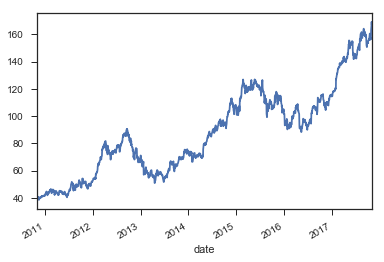

In [5]:
#verify data is groovy 
df.aapl.plot();

# Z-Scores 

A z-score is a useful statistic which indicates how many standard deviations an element is from the mean.  It can be calculated from the following formula:

$$ Z = \frac{X - μ}{σ} $$

Where z is the z-score, $X$ is the value of the element, $μ$ is the population mean, and $σ$ is the standard deviation. The z-score allows us to calulate the probability of the value X occuring in an normal distribution. If we have a Z-score of 2, that means we constrain the normal distribution by 2 standard deviations, and 95.4% of the data falls within those constraints. There is only a 4.6% chance that data will fall outside of those bounds. You can visit [this site](http://access-excel.tips/wp-content/uploads/2015/09/z-score-02.png) for a standard z-score table.  

A random variable here is described by a normal distribution: 

<img src='https://i0.wp.com/i887.photobucket.com/albums/ac73/archaeopteryx1/bell-curve.jpg' height="542" width="542">

And here is some raw stock data: 

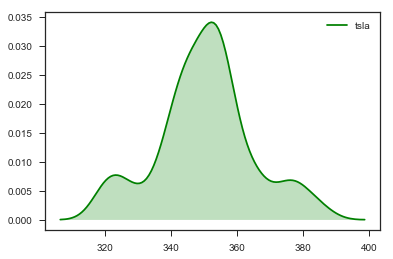

In [6]:
sb.kdeplot(df['tsla'][0:50], color="g", shade=True)

This is a kernel density estimation (probability density function) of Ford stock from the past 50 days. Notice any similarities?  

A stock is typically assumed to be a normal distribution, and so we can apply the Z-score idea and other statistical analyis. If a stock price falls outside of the Z-bounds we set, then there is a high probability it is over/undervalued. The market should then correct itself to a more stable value. One might say, its regressing to the mean :) In reality a stock is actually a fat-tailed distribution with incoming prices having some correlation to the prices which came right before it. We could transform it, but thats for another project. 

#### A note before we proceed: 

I should note, that many of the trends in this analysis are already priced into the stock. This is actually just a "smart" version of [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) that adapt to changing statistical properties. Professional quants have discovered this stuff a while ago. But for the hobby trader, using this statiscal tool to augment intuitive judgements that should, hopefully, make for better trading. Put more elegantly, a decent mind  with a weak computer and a good process is incredibly powerful.

## The Analysis

I start by creating a moving average and moving standard-deviation thresholds of a stock, and map the real price to these smoothed prices. I then multiply the smoothed curves by a z-score factor which push the buy/sell thresholds further away from the mean.  If the real stock crosses these thresholds, then that is a trigger signal that we should buy or sell the stock.  These triggers are dynamic, and automatically adjust themselves to incoming stock information.

After a bunch of optimizaiton and fine tuning on historical traning data, and we get the best z-scores and window sizes for the moving averages, all in a neat little dataframe. We can use this metadata for trading. 

### Grid Search against all  hyperparameters (z scores, rolling window)

The next step is to take these 3 hyperparamters - two Z-scores and rolling window size - and perform a grid search to find the best values, trained on each stock's historical data. 

### WARNING: 

only run if you want to retune. Not advised, since it takes a very long time to process. Only retune if you are testing a new hypothesis. The model is already tuned, so rerunning on the same hypothesis wouldn't yeild much, and it will just slow your computer down for 3 hours. 

**scroll down to the next cell to view the analysis**

In [7]:
hyperpath = 'hyper/'

########### Hyper Parameters ##############
#smaller batch of hyperparams for quicker testing 
small_test = {'up_thresholds'  : [1.0, 1,4, 1.8, 2.4] ,
             'low_thresholds'  : [1.0, 1,4, 1.8, 2.4],
             'rolling_windows' : [40,100, 220, 300],
             }

big_test = {'up_thresholds'  : [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4],
            'low_thresholds'  : [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4],
            'rolling_windows' : [10, 20, 40, 60, 80, 100, 120, 150, 200, 220, 240, 260, 280, 300],
            }

In [8]:
#                     plotEachON = True 
#                     if plotEachON == True:     #Plot deterministic plot and results of grid search
#                         fig = plt.figure(figsize=(14, 5))
#                         ax0 = fig.add_subplot(1,1,1)
#                         ax0.plot(df[SOI])
#                         r2a = '%s_roll_above' % SOI 
#                         r2b = '%s_roll_below' % SOI
#                         ax0.plot(rolling_df[r2b], color=(rgb(255), rgb(102), rgb(102), 0.4))
#                         ax0.plot(rolling_df[r2a], color=(rgb(28), rgb(232), rgb(174), 0.4))
#                         plt.scatter(trades_df.index, trades_df[SOI+'_buy'], s=40, c='red')
#                         plt.scatter(trades_df.index, trades_df[SOI+'_sell'], s=40, c='lime')
#                         plt.title(SOI + str(rolling_window) +' days')
#                         plt.show()

########## Helper Functions ##############

def rolling_compute(series, window, computation):
    #perform rolling computation 
    
    new_series = series[::-1] #reverse
    new_series = new_series.rolling(window=window, min_periods=window)
    
    if computation == 'mean':
        new_series = new_series.mean()[::-1]
        return new_series
    
    elif computation == 'std':
        new_series = new_series.std()[::-1]
        return new_series
    
    else: 
        print ('ERROR check data') 

def compute_rolling_data(ticker, df): 
    #rolling mean, std, buy/sell thresholds 
    
    prices = df[ticker]
    prices = prices[prices > 0] #get rid of NAN
    
    roll_array = [ticker+'_roll_above',ticker+ '_roll_below']
    rolling_df = pd.DataFrame() #save rolling data to new dataframe

    # rolling calulations 
    rolling_mean = rolling_compute(prices, rolling_window, 'mean')
    rolling_std = rolling_compute(prices, rolling_window, 'std')

    #calculate the upper and lower bands 
    roll_above = rolling_mean+(up_threshold*rolling_std)
    roll_above = pd.Series.to_frame(roll_above, roll_array[0])

    roll_below = rolling_mean-(low_threshold*rolling_std)
    roll_below = pd.Series.to_frame(roll_below, roll_array[1])

    #concat 
    frames = [prices, roll_above, roll_below]
    rolling_df = pd.concat(frames, axis=1)

    #check if the current prices lay within critical buy/sell thresholds
    rolling_df_columns = [ticker, ticker+'_buy', ticker+'_sell' ]
    rolling_df_bin = pd.DataFrame(columns=rolling_df_columns, index=df.index)
    
    rolling_df_bin[ticker] = prices
    rolling_df_bin[ticker+'_buy'] = rolling_df[ticker] < rolling_df[ticker+'_roll_below']
    rolling_df_bin[ticker+'_sell'] = rolling_df[ticker] > rolling_df[ticker+'_roll_above'] 

    return rolling_df, rolling_df_bin

def init_performance_df(trade_log, ticker, index=df.index):
    #dataframe for logging performance metrics - buy sell profile
    num = pd.Series(data=np.arange(trade_log.shape[0]), index=index) 
    num = pd.Series.to_frame(num, 'num') #add numerical index column (used to filter later)
    trade_log = pd.concat([trade_log, num], axis=1)
    trade_log = trade_log.ix[trade_log[ticker+'_buy']+trade_log[ticker+'_sell'] > 0] #remove days within z-bounds
    trade_log = trade_log.sort_index(ascending=True) #change sorting for cleaning algorithm
    return trade_log

def buy_sell_profile(trade_log):
    #build an ordered buy/sell historical profile 
    old_buy = False 
    old_sell = False 
    keep_rows=[]
    for index, row in (trade_log.iterrows()): #only keep first sell/trade days
        new_buy = row[1] 
        new_sell = row[2]
        num = row[3] #numerical index 
        #print new_buy, new_sell
        if old_buy==False  and new_buy!=False: #set flag to remove duplicate buy notifications
            keep_rows.append(num)    
        if old_sell==False and new_sell!=False: #set flag to remove duplicate sell notifications
            keep_rows.append(num) 
        old_buy = new_buy #shift 
        old_sell = new_sell
    trade_log = trade_log[trade_log['num'].isin(keep_rows)]
    trade_log = trade_log.sort_index(ascending=False) #revert to normal sorting
    return trade_log 

def compute_metrics(trade_log, result_array):
    #calculate final performance metrics 
    
    old_num = 0
    old_price = 0
    price = 0
    percent_compiler = []
    for index, row in (trade_log.iterrows()): #performace calulations            
        value = row[0]
        buys = row[1]
        sells = row[2]
        num = row[3]
        try:
            delta = num - old_num
            if delta == 0: #occurs on day 0 (today) trades. Prevent 0 division error  
                delta += 1
            if buys==True: 
                old_price = value
            if sells==True:
                price = value
            gain = price-old_price
            #print price, old_price, delta, value, num
            if (buys == True): 
                trade_log.set_value(index, 'delta', delta) #add in delta between trades
                trade_log.set_value(index, 'gain', gain) 
                percent = gain/old_price
                trade_log.set_value(index, 'percent', percent)
                percent_compiler.append(percent)
            else:
                trade_log.set_value(index, 'delta', np.nan)
                trade_log.set_value(index, 'gain', np.nan)
                trade_log.set_value(index, 'percent', np.nan)
            old_num = num

        except KeyError:
            continue 
    
    ip1k = 1000 #seed 
    for i, p in enumerate(percent_compiler):
        ip1k = ip1k*(1+p) #$1000 invested today would be  
    
    try:
        ips = trade_log['gain'].sum() #increase per share
        apc = trade_log['percent'].mean() #average percent change
        dph = trade_log['delta'].mean() #days per holding
        tpy = 260.0/dph #trades per trading year (260 days)
        check = 1*(1+(apc/tpy))
    
    except KeyError: #usually occurs on 'gain' calc 
        return trade_log, result_array, 0
    
    if check > 0: 
        epy = (1*(1+(apc/tpy))**tpy)-1 #avg earnings per year (interest formula)
    else: 
        epy = 'NaN' #avoid negative number^fractional exponent error (drop later)
    
    results = [rolling_window, up_threshold, low_threshold, ip1k, ips, apc, dph, tpy, epy]
    result_array = np.append(result_array,[results],axis=0) #convert to np array
    
    return trade_log, result_array, 1

## "fit" the model 

In [9]:
tune = False 
if tune:
    working_df = df.copy()
    main_start = time.time() #for whole program 
    hyperparams = big_test #dict 
    r_cols = ['window_size', 'up_z', 'low_z', '1000_today',
              'inc_per_share', 'avg_p_change', 'days_per_hold',
              'trades_per_year', 'earnings_per_year'] #for analysis later 

    for SOI in working_df.columns: #change to 'df' for all stocks in question
        print SOI
        start = time.time() #reset timer for new stock  
        result_array = np.empty((0, 9)) #intialize 
        
        for rolling_window in hyperparams['rolling_windows']:
            for up_threshold in hyperparams['up_thresholds']: 
                for low_threshold in hyperparams['low_thresholds']:
#                     print (SOI, rolling_window, up_threshold, low_threshold)
                    
                    ### Compute the rolling parameters of each data series ###
                    rolling_df, rolling_df_bin = compute_rolling_data(SOI, df)

                    ### Quantify perfomance of different hyperparamter combos ###
                    trades_df = init_performance_df(rolling_df_bin, SOI) 
                    trades_df = buy_sell_profile(trades_df)
                    trades_df, result_array, breaker = compute_metrics(trades_df, result_array)
                    if breaker == 0: 
                        continue  #metric compute failed 
                        
        #end of stock 
        results_hyper = pd.DataFrame(result_array, columns=r_cols)
    #     print results_hyper.head(4)
        filename = 'results_hyper_' + SOI +'.csv'
        fullpath = os.path.join(hyperpath, filename)
        results_hyper.to_csv(fullpath) #for safe keeping :)
        print 'finished  %s! In %f sec' % (SOI, (time.time() - start))

    print 'finished everything!'
    print 'finished  %s! In %f sec' % ('all stocks', (time.time() - main_start))
    
else: 
    print 'not tuning'

not tuning


# Exploratory Analysis of optimized hyperparameters and results 

The numbers are crunched. Lets plot probability density functions of hyperparameters and rank results. 

In [10]:
### helper functions ###

def plotFinalCharts(tuned_df, independent_var, plot=True):
    if plot:
        fig = plt.figure(figsize=(12, 5))
        ax0 = plt.subplot2grid((4,4), (0,0), colspan=4, rowspan=2)
        plt.scatter(tuned_df[independent_var], tuned_df['up_z'],s =12,  c='cyan')
        plt.scatter(tuned_df[independent_var], tuned_df['low_z'],s =12,  c='red')
        plt.ylabel('z score')
        plt.xlabel('earnings per year')
        plt.legend()
        ax1 = ax0.twinx()
        plt.scatter(tuned_df[independent_var], tuned_df['window_size'], s=12, c='green')
        plt.ylabel('window size')

        ax2 = plt.subplot2grid((3,4), (2, 0), colspan=1)
        sb.kdeplot(tuned_df['window_size'],legend=True, shade=True, color='g', vertical=False) #sb KDE 
        ax3 = plt.subplot2grid((3,4), (2, 1), colspan=1)
        sb.kdeplot(tuned_df['up_z'],legend=True, shade=True, color='c', vertical=False) #sb KDE 
        ax4 = plt.subplot2grid((3,4), (2, 2), colspan=1)
        sb.kdeplot(tuned_df['low_z'],legend=True, shade=True, color='r', vertical=False) #sb KDE 
        ax5 = plt.subplot2grid((3,4), (2, 3), colspan=1)
        sb.kdeplot(tuned_df['earnings_per_year'],legend=True, shade=True, color='m', vertical=False) #sb KDE 

        plt.show()

def plotEachChart(ticker, data, independent_var, plot=False):
    if plot == True:     
        fig = plt.figure(figsize=(21, 7))
        ax0 = plt.subplot2grid((2,3), (0,0), colspan=3)
        ax0.plot(df[ticker])
        r2a = ticker + '_roll_2_above'
        r2b =  ticker + '_roll_2_below'
        plt.title(ticker)

        ax1 = plt.subplot2grid((2,3), (1,0), colspan=1)
        ax1 = sb.boxplot(y="window_size", x = independent_var, data=data, orient='h')
        ax1.set_ylabel('rolling window day size')
        ax1.set_xlabel(independent_var)
        ax1.legend(loc=2)

        ax2 = plt.subplot2grid((2,3), (1,1), colspan=1)
        ax2 = sb.boxplot(y="up_z", x = independent_var, data=data, orient='h')

        ax3 = plt.subplot2grid((2,3), (1,2), colspan=1)
        ax3 = sb.boxplot(y="low_z", x = independent_var, data=data, orient='h')
        ax2.legend(loc='best')
        plt.show()
        
def remove_overfit(tuned_df, ticker, analysis_rows, epy_std_thresh, independent_var):

    top_params = tuned_df[:analysis_rows] #number of top performing combos to analyze 
    top_std = top_params.std()
    i = 0 
    while (True): #parse out overfitted hyperparameter combos
        top_params = tuned_df[i:i+analysis_rows] #remove top performing row (overfitted), alter if there is more than one 
        top_std = top_params.std()
        i+= 1
        if i > 1: 
#             print ticker, '\n', top, top_std, '\n' # see which stocks needed adjustment 
            pass 
        if top_std[independent_var] < epy_std_thresh:
            break 

    top_mean = [top_params.mean()]

    return top_mean, top_params

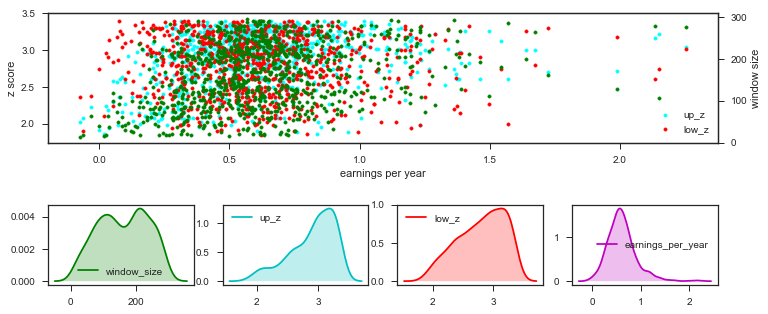

       window_size   up_z  low_z  1000_today  inc_per_share  avg_p_change  \
count       845.00 845.00 845.00      845.00         845.00        845.00   
mean        161.91   2.91   2.80    2,090.95          36.40          0.90   
std          75.54   0.36   0.39      955.66          66.46          0.62   
min          13.00   1.86   1.84        0.00        -232.01         -0.08   
25%         100.00   2.68   2.50    1,556.12          12.51          0.48   
50%         164.00   3.00   2.86    1,899.04          24.36          0.75   
75%         222.00   3.20   3.14    2,528.83          41.49          1.15   
max         296.00   3.40   3.40    6,877.36       1,062.20          5.11   

       days_per_hold  trades_per_year  earnings_per_year  
count         845.00           845.00             845.00  
mean          483.22             1.02               0.61  
std           291.17             1.04               0.29  
min            29.90             0.17              -0.07  
25%        

,SOI,window_size,up_z,low_z,1000_today,inc_per_share,avg_p_change,days_per_hold,trades_per_year,earnings_per_year
442,geo,276.00,3.04,3.02,"2,604.88",19.06,1.60,129.60,2.01,2.25
691,nvda,106.00,3.22,2.74,"6,877.36",90.54,4.57,506.20,0.56,2.15
326,nbr,278.00,3.16,2.60,"2,922.18",10.53,1.92,219.40,1.19,2.13
605,phm,128.00,2.72,3.18,"3,471.18",12.74,2.47,339.80,0.80,1.99
401,exp,162.00,2.70,3.30,"3,716.27",47.76,2.72,421.90,0.70,1.72
806,evhc,264.00,3.00,2.80,"2,752.36",44.51,1.75,281.00,0.93,1.67
16,clgx,200.00,3.00,3.26,"2,801.11",16.19,1.80,298.00,0.98,1.64
458,x,286.00,2.60,2.00,"2,517.19",16.98,1.52,238.10,1.12,1.57
737,algn,180.00,3.12,2.74,"6,527.19",102.83,1.88,345.60,0.79,1.54
796,z,112.00,3.26,2.26,"2,672.55",27.51,1.67,313.50,0.83,1.50


In [11]:
independent = 'earnings_per_year' #independent variable to analyze on  
epy_std_thresh = 0.15 #std dev threshold of earnings per year % that must be exceed to warrant drop
analysis_rows = 10 #num of top performing rows to include in analysis
tuned_list = np.empty((0,9))

param_cols = [u'window_size', u'up_z', u'low_z', u'earnings_per_year'] #top.columns
soi_list = []

for i, SOI in enumerate(df.columns): 
#     print SOI
    filename = 'results_hyper_' + SOI + '.csv' 
    fullname = os.path.join(hyperpath, filename)
    
    if os.path.isfile(fullname) == False: #see if path exists 
#         print SOI, 'file does not exist'
        continue 
    
    results_hyper = pd.read_csv(fullname)
    results_hyper = results_hyper.drop(['Unnamed: 0'], axis=1).dropna()
    results_hyper = results_hyper.sort_values(by=independent, ascending=False)
    param_cols = results_hyper.columns

    t, top = remove_overfit(results_hyper, SOI, analysis_rows, epy_std_thresh, independent)
    
    soi_list.extend([SOI])
    tuned_list = np.append(tuned_list, t,axis=0) #append top results to trades df 
    
    plotEachChart(SOI, top, independent, plot=False)
    
tuned_params = pd.DataFrame(data=tuned_list, columns=param_cols)
soi_names = pd.DataFrame(data=soi_list, columns=['SOI'])

tuned_params = pd.merge(soi_names, tuned_params, how='outer', left_index=True, right_index=True)
tuned_params = tuned_params.sort_values(by=independent, ascending=False)
# tuned_params = tuned_params.drop(tuned_params.index[0]) #drop insanely good BRK stock 

plotFinalCharts(tuned_params, independent, plot=True)

tuned_params.to_csv('data/tuned_params.csv')
print tuned_params.describe()
tuned_params.head(10)

### What are we looking at? 

The Dataframe above shows us some stats. For each stock, we get the optmized window size, z-score bounds, and earnings statistics. We should be cautious of the first couple of trades that are way more sucessful than the others, since they may be overfit/outliers. This is why seeing the distributions in the charts is useful. 

The scatter plot shows the range of the hyperparameters (z-bounds, rolling window size) vs. average earnings per year. We can see some clustering. Window size is bimodal, and if we throw out low values (overfit, generally around 10-20 day windows) There is a peak around 220 days. Both upper and lower z-score bounds tend towards a score of 3, but in a non-normal distribution with high variance. Finally earnings per share is around 40%, which is a great ROI. Too great. We should be weary of overfitting the model since this is only training data. We'll have to validate and test later. It'll be tricky since we don't have much data to work with...

# Calculate stocks that are awaiting a trade

Intial Analysis looks good! Let's see what stocks the algrithim deems under/overvalued based on the results. We can use this as informed buy/sell trading signals. 

In [12]:
trades_calc = tuned_params.set_index('SOI') #set both index SOI to easily grab key values 
trades_calc = trades_calc.transpose() #for ease of iterations
a = []
up_leeway = 1
low_leeway = 1
print 'up leeway: ', up_leeway
print 'low leeway: ', low_leeway

for SOI in trades_calc.columns: 
    window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
    up_z = trades_calc[SOI]['up_z']
    low_z = trades_calc[SOI]['low_z']
    epy = trades_calc[SOI]['earnings_per_year']
    tpy = trades_calc[SOI]['trades_per_year']
    ROI = df[SOI][:window] #region of interest is size of optimized window 
    current_price = current[SOI][0] #float of current price 
    
    up_thresh = mean = ROI.mean()+ROI.std()*up_z
    low_thresh = mean = ROI.mean()-ROI.std()*low_z
    
    #buy/sell triggers 
    if current_price<(low_thresh*low_leeway):
        buy=1
        queue_b = 1
    else:
        buy='NaN'
        queue_b = 0      
    if current_price>(up_thresh*up_leeway):
        sell=1
        queue_s = 1
    else:
        sell='NaN'
        queue_s = 0
    queue = queue_b+queue_s
    
    values = [current_price, up_thresh, low_thresh, tpy, epy, buy, sell, queue]
    a.append(values)
    
index = ['current_price', 'up_thresh', 'low_thresh', 'trades_per_year', 'earnings_per_year', 'buy', 'sell', 'queue']   
stock_stats = pd.DataFrame(data=np.array(a).T, index=index, columns=trades_calc.columns)

stock_stats_vis = stock_stats.transpose() #visualization options 
stock_stats_vis = stock_stats_vis[stock_stats_vis['queue'] != '0']
buys = stock_stats_vis[stock_stats_vis['buy'] != 'NaN'] #buys only 
sells = stock_stats_vis[stock_stats_vis['sell'] != 'NaN'] #buys only 

## TO DO ##
# comment these out (one at a time) to see buys only, sells only, or both. 
stock_stats_vis
# sells
# buys

up leeway:  1
low leeway:  1


,current_price,up_thresh,low_thresh,trades_per_year,earnings_per_year,buy,sell,queue
SOI,,,,,,,,
phm,30.41,30.1771284546,19.0848628253,0.804876763573,1.98953468925,NaN,1,1
abmd,188.89,186.518256838,89.0352007016,0.825392926756,1.36128842276,NaN,1,1
idti,31.01,29.3549004559,21.9786532362,0.503506184899,1.13832775538,NaN,1,1
kmpr,64.3,64.0253853182,23.5146236025,0.60052978421,1.11416961661,NaN,1,1
wbmd,0.0,96.0780174866,9.63443736982,1.2912558907,1.08297121672,1,NaN,1
wcg,200.91,193.216270401,160.78219375,0.513752565083,1.02796870856,NaN,1,1
amzn,1103.68,1088.61102267,912.974241534,0.448863962095,1.00378898048,NaN,1,1
swk,161.04,159.720078786,103.065955865,2.19604519774,0.850540367985,NaN,1,1
tel,91.87,91.8199504607,64.0352316791,0.456797380924,0.813812117794,NaN,1,1


# To check specific scores

Seeing the global averages is useful to get a guage for the general health of the model, but it would be nice to see scores and predictions on specific stocks. This is especially true since this model is intended for the personal/hobby trader, and not a full fledged hedge fund. I say that because a hedge fund has the resources and capital to invest into a broad portofolio, but smaller scale traders would need to pick stocks with more discretion and would likeley end up with a more concentrated portfolio. So lets built those functions. 

In [13]:
# quick peek at the data, stats values
def peek_raw_data(stock_list):
    for SOI in stock_list:
        print SOI + ' analysis'
        name = 'results_hyper_'+SOI+'.csv'
        name = os.path.join(hyperpath, name)
        return pd.read_csv(name)


# only look at the specific scores of interst 
def check_score_simple(stock_list):
    for SOI in stock_list:
        window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
        up_z = trades_calc[SOI]['up_z']
        low_z = trades_calc[SOI]['low_z']
        epy = trades_calc[SOI]['earnings_per_year']
        print '\n', SOI
        print 'window: ', window
        print 'up_z: ', up_z
        print 'low_z: ', low_z
        print 'epy: ', epy
        
        
        
#view top results from optimization 
def check_top_results(stock_list):
    for SOI in stock_list:
        filename = 'results_hyper_' + SOI + '.csv' 
        fullname = os.path.join(hyperpath, filename)
        if os.path.isfile(fullname) == False: #see if path exists 
            #print SOI, 'file does not exist'
            continue 
        results_hyper = pd.read_csv(fullname)
        results_hyper = results_hyper.drop(['Unnamed: 0'], axis=1)
        results_hyper = results_hyper.dropna()
        results_hyper = results_hyper.sort_values(by=independent, ascending=False)
        #results_hyper = results_hyper.drop(results_hyper.columns[[3,4,5,6,7]], axis=1)
        print SOI 
        print results_hyper.head(5)
        print 
        
        
#plot a specific stock with z-score bounds visible     
def plot_stocks(stock_list):
    for SOI in stock_list:
        print SOI
        window = int(trades_calc[SOI]['window_size']) #optimized hyperparameters 
        up_z = trades_calc[SOI]['up_z']
        low_z = trades_calc[SOI]['low_z']
        epy = trades_calc[SOI]['earnings_per_year']
        
        prices = df[SOI] [df[SOI] > 0 ]

        roll_avg = prices[::-1].rolling(window=window, min_periods=window).mean()[::-1] #rolling mean 
        roll_std = prices[::-1].rolling(window=window, min_periods=window).std()[::-1] #rolling std dev
        roll_z_above = roll_avg+(up_z*roll_std)
        roll_z_below = roll_avg-(low_z*roll_std)

        ### PLOT FIGURE ###
        fig = plt.figure(figsize=(14, 5))   
        ax1 = fig.add_subplot(1,1,1)
        fig.autofmt_xdate() #rotate date labels 
        title = 'Analysis of  ' + SOI
        plt.title(title)

        ax1.plot(df[[SOI]]) #time wise plot
        ax1.plot(roll_avg, color=(rgb(211), rgb(236), rgb(245))) #MEAN 
        ax1.plot(roll_z_above, color='cyan')
        ax1.plot(roll_z_below, color='red')

        #LEGEND 
        up_name = 'upper_z: '+str(up_z)
        low_name = 'lower_z: '+str(low_z)
        window_name = 'window_size: '+str(window)
        epy_name = 'historic epy: ' + str(epy)
        cyan_patch = mpatches.Patch(color='cyan',
                                    label=up_name)
        red_patch = mpatches.Patch(color='red',
                                   label=low_name)
        win_patch = mpatches.Patch(color='green', label=window_name)
        epy_patch = mpatches.Patch(color='m', label=epy_name)

        plt.legend(handles=[cyan_patch, red_patch, win_patch, epy_patch], loc='best')
        plt.show()



## Play around with graphs!

change the value of the SOI list to plot your specific stocks of interst. 

nvda


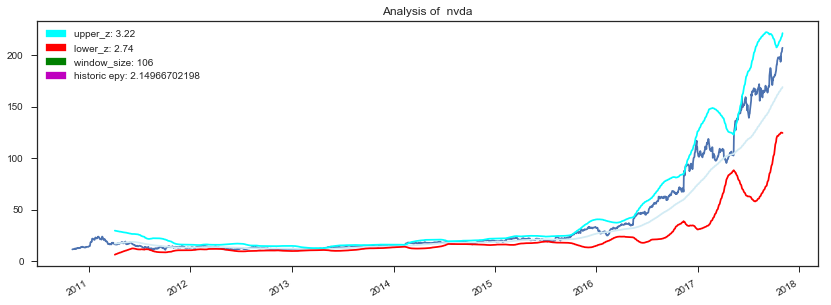

In [14]:
SOI = ['nvda']
#peek_raw_data(SOI);
# check_score_simple(SOI);
# check_top_results(SOI);
plot_stocks(SOI)

## Or just plot all the buy/sell signals. 

wbmd


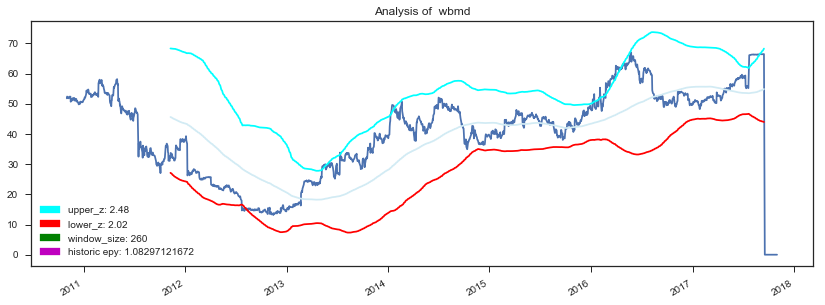

ddd


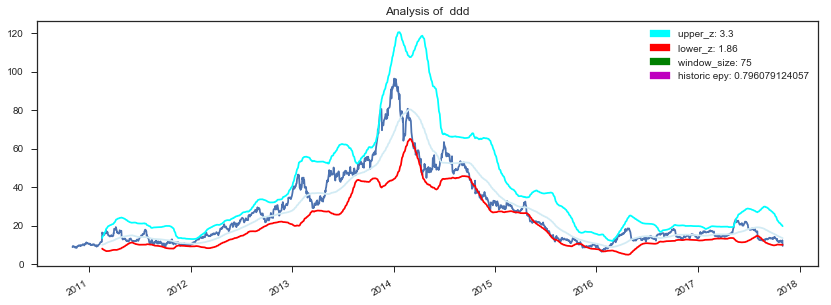

uaa


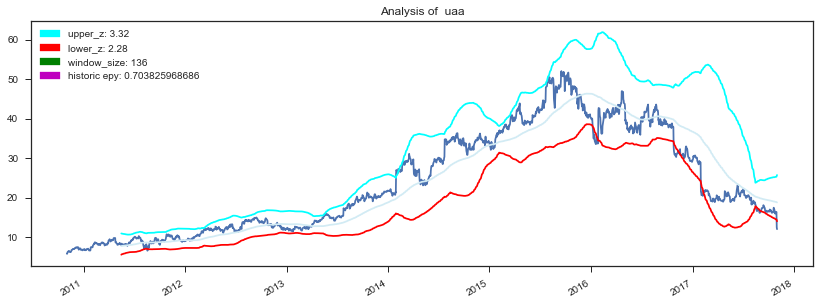

bkh


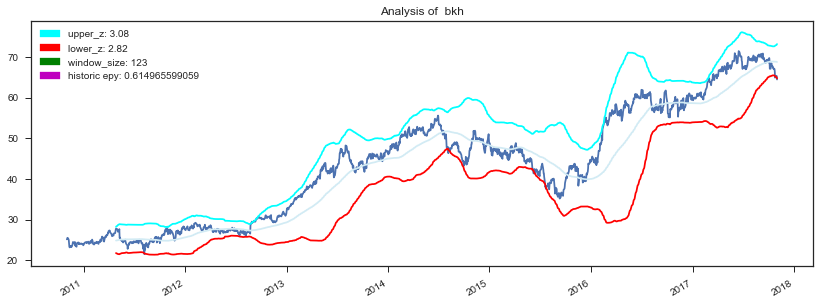

coh


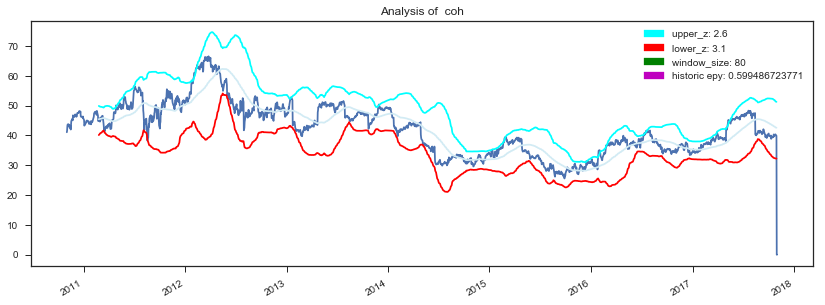

odp


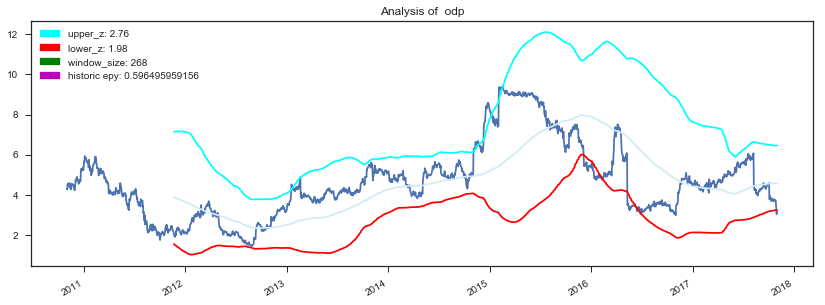

achc


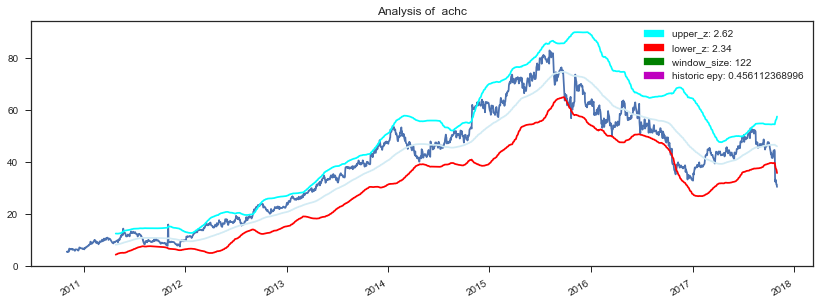

lvlt


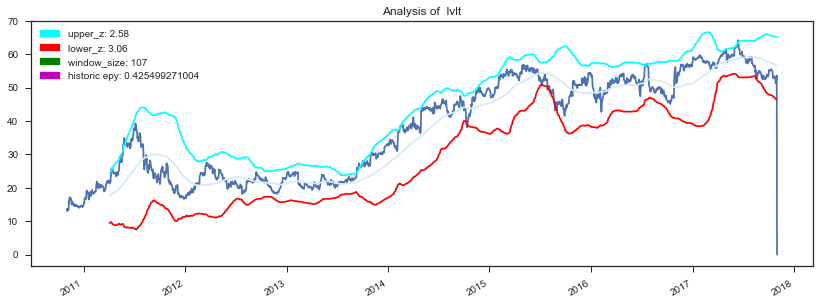

dps


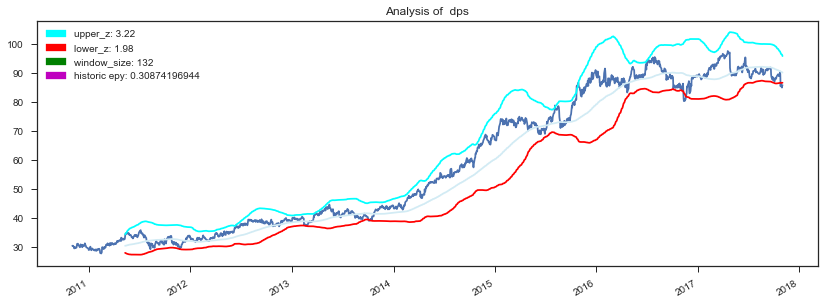

int


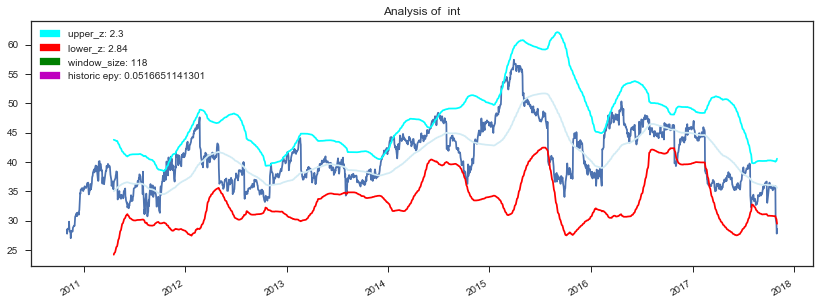

In [15]:
stock_stats_trade_list = buys.transpose()
plot_stocks(list((stock_stats_trade_list.columns)))

# Merge Tuned Parameters With Metadata

In [16]:
meta_data = pd.read_csv('data/company_metadata.csv')
meta_data['Ticker'] = meta_data['Ticker'].apply(lambda x : x.lower())

stock_metadata = meta_data.merge(tuned_params, left_on='Ticker', right_on='SOI', how='inner', copy=True)
stock_metadata = stock_metadata.drop('SOI', axis=1)
stock_metadata

,Ticker,Name,Sector,Industry,window_size,up_z,low_z,1000_today,inc_per_share,avg_p_change,days_per_hold,trades_per_year,earnings_per_year
0,a,Agilent Technologies Inc.,Healthcare,Medical Laboratories & Research,284.00,2.86,3.06,"1,729.35",25.24,0.73,443.90,0.59,0.61
1,aan,"Aaron's, Inc.",Services,Rental & Leasing Services,248.00,2.88,2.30,"2,185.68",21.74,0.43,243.28,1.43,0.43
2,aap,Advance Auto Parts Inc.,Services,Auto Parts Stores,60.00,2.60,3.30,"1,190.28",12.82,0.19,115.00,2.26,0.20
3,aapl,Apple Inc.,Consumer Goods,Electronic Equipment,288.00,2.86,2.08,"2,461.33",77.95,1.46,972.60,0.27,0.65
4,abc,AmerisourceBergen Corporation,Services,Drugs Wholesale,217.00,2.38,2.46,915.46,2.34,0.31,358.15,1.33,0.30
5,abmd,"ABIOMED, Inc.",Healthcare,Medical Appliances & Equipment,294.00,2.74,2.20,"2,822.17",22.78,1.82,370.90,0.83,1.36
6,abt,Abbott Laboratories,Healthcare,Medical Appliances & Equipment,74.00,3.02,2.54,"2,357.71",27.15,1.26,"1,402.50",0.19,0.46
7,acc,"American Campus Communities, Inc.",Financial,REIT - Residential,84.00,2.70,3.28,"1,431.11",13.52,0.43,157.60,1.79,0.46
8,achc,"Acadia Healthcare Company, Inc.",Healthcare,Specialized Health Services,122.00,2.62,2.34,541.26,-4.77,0.47,261.34,1.06,0.46
9,aciw,"ACI Worldwide, Inc.",Technology,Technical & System Software,99.00,3.26,2.66,"2,200.50",11.28,0.68,475.95,0.65,0.53
